# TEST PLAYGROUND
#Just for dev puproses!


In [29]:
import pickle
import myLibrary as mL
import pandas as pd
import numpy as np

from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
import tensorflow as tf
from keras import backend as K

DP = mL.DataProcessor

In [30]:
DATAFILE = "dataset_GOM_1_A_A.pickle"
with open(f'data/datasets/type_A/{DATAFILE}', 'rb') as f:
    # load the object from the file using pickle.load()
    dataset = pickle.load(f)

data = dataset["data"]
data

,WDIR_42001,WSPD_42001,PRES_42001,ATMP_42001,WTMP_42001,DEWP_42001,WDIR_42002,WSPD_42002,PRES_42002,ATMP_42002,...,WDIR_42039_ERA5,WSPD_42039_ERA5,ATMP_42039_ERA5,WSPD_42035_ERA5,WSPD_42001_ERA5,DEWP_42020_ERA5,ATMP_42019_ERA5,WTMP_42039_ERA5,WSPD_42002_ERA5,PRES_42039_ERA5
2002-01-01 00:00:00,66.0,9.3,1017.1,22.3,25.5,16.8,39.0,10.5,1016.1,21.7,...,246.007357,5.756333,13.882608,8.031200,9.867456,10.834305,11.708612,21.781113,9.820263,1019.426223
2002-01-01 01:00:00,66.0,9.3,1017.1,22.3,25.5,16.8,39.0,10.5,1016.1,21.7,...,247.678051,5.579721,14.020573,8.216895,9.782997,10.975658,11.926516,21.781113,10.465795,1019.792677
2002-01-01 02:00:00,67.0,9.4,1017.2,21.9,25.5,16.6,36.0,10.9,1016.1,21.7,...,250.591891,5.582730,14.070538,8.454808,9.517146,11.111871,12.166319,21.781113,11.760698,1019.725358
2002-01-01 03:00:00,69.0,9.1,1017.2,22.4,25.5,16.9,32.0,12.7,1015.9,20.8,...,253.468273,5.633966,14.058979,8.471692,8.911373,11.239089,12.361607,21.781113,11.910608,1019.833394
2002-01-01 04:00:00,70.0,9.0,1017.1,22.5,25.5,16.3,33.0,12.7,1015.8,21.0,...,251.493918,5.638108,13.986641,8.698506,8.481407,11.332468,12.482585,21.781113,11.716782,1019.804620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,195.0,0.5,1015.0,25.6,24.7,24.5,22.0,0.6,1015.9,25.1,...,28.180851,8.602918,22.730194,2.533178,0.601025,19.323104,21.847184,24.392457,1.062895,1016.581840
2022-12-31 20:00:00,210.0,1.0,1015.0,25.3,24.5,24.3,88.0,1.2,1015.4,24.7,...,22.969408,7.734290,22.564177,2.669909,0.979714,19.245361,22.052563,24.392457,1.330008,1016.363260
2022-12-31 21:00:00,231.0,0.6,1014.7,26.4,24.7,24.4,87.0,1.7,1014.9,24.6,...,14.655430,6.485218,22.377552,3.147255,2.067327,19.338348,22.260412,24.392457,1.770915,1016.186435
2022-12-31 22:00:00,18.0,0.7,1014.9,25.4,24.7,24.1,90.0,2.5,1014.9,24.5,...,20.371840,3.294807,24.068445,3.469271,1.554299,18.567779,22.101541,24.885927,2.483432,1017.067575


# Test Data


In [31]:
#TEST DATA FOR WIND SPEED
# n = 1000
#
# data = {}
# for col in range(1, 5):
#     key = f'WDIR_{col}' if col % 2 != 0 else f'WSPD_{col}'
#     data[key] = []
#
#     for row in range(1, n+1):
#         value = (row-1) * 4 + col
#         data[key].append(value)
#
# timestamps = pd.date_range(start='2020-01-01 01:00:00', periods=n, freq='H')
# data = pd.DataFrame(data, index=timestamps)
# data

In [32]:
# TEST DATA FOR CUSTOM LOSS FUNCTION
# n = 1000  # Number of rows
#
# data = {
#     'WDIR_1': [1.1] * n,
#     'WSPD_1': [1.2] * n,
#     'WDIR_2': [2.1] * n,
#     'WSPD_2': [2.2] * n,
#     'WDIR_1_ERA5': [100.1] * n,
#     'WSPD_1_ERA5': [100.2] * n,
#     'WDIR_2_ERA5': [200.1] * n,
#     'WSPD_2_ERA5': [200.2] * n
# }
#
# timestamps = pd.date_range(start='2020-01-01 01:00:00', periods=n, freq='H')
# data = pd.DataFrame(data, index=timestamps)
# data

In [33]:
data_supervised = DP.data_to_supervised(data, n_in=3, n_out=1)
data_supervised

,WDIR_42001(t-3),WSPD_42001(t-3),PRES_42001(t-3),ATMP_42001(t-3),WTMP_42001(t-3),DEWP_42001(t-3),WDIR_42002(t-3),WSPD_42002(t-3),PRES_42002(t-3),ATMP_42002(t-3),...,WDIR_42039_ERA5(t),WSPD_42039_ERA5(t),ATMP_42039_ERA5(t),WSPD_42035_ERA5(t),WSPD_42001_ERA5(t),DEWP_42020_ERA5(t),ATMP_42019_ERA5(t),WTMP_42039_ERA5(t),WSPD_42002_ERA5(t),PRES_42039_ERA5(t)
2002-01-01 03:00:00,66.0,9.3,1017.1,22.3,25.5,16.8,39.0,10.5,1016.1,21.7,...,253.468273,5.633966,14.058979,8.471692,8.911373,11.239089,12.361607,21.781113,11.910608,1019.833394
2002-01-01 04:00:00,66.0,9.3,1017.1,22.3,25.5,16.8,39.0,10.5,1016.1,21.7,...,251.493918,5.638108,13.986641,8.698506,8.481407,11.332468,12.482585,21.781113,11.716782,1019.804620
2002-01-01 05:00:00,67.0,9.4,1017.2,21.9,25.5,16.6,36.0,10.9,1016.1,21.7,...,247.676567,5.438761,13.804677,8.898239,8.035067,11.430130,12.548997,21.781113,11.294205,1019.716671
2002-01-01 06:00:00,69.0,9.1,1017.2,22.4,25.5,16.9,32.0,12.7,1015.9,20.8,...,249.327228,5.617903,13.556713,9.086013,8.451408,11.504233,12.615050,21.781113,10.893404,1020.098869
2002-01-01 07:00:00,70.0,9.0,1017.1,22.5,25.5,16.3,33.0,12.7,1015.8,21.0,...,249.422157,5.999083,13.194649,9.266253,8.955747,11.601895,12.729567,21.781113,9.970325,1020.017435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,124.0,0.8,1017.1,24.6,24.4,23.8,316.0,1.3,1017.8,24.7,...,28.180851,8.602918,22.730194,2.533178,0.601025,19.323104,21.847184,24.392457,1.062895,1016.581840
2022-12-31 20:00:00,107.0,1.1,1016.6,24.9,24.4,23.9,104.0,0.0,1017.7,25.8,...,22.969408,7.734290,22.564177,2.669909,0.979714,19.245361,22.052563,24.392457,1.330008,1016.363260
2022-12-31 21:00:00,147.0,1.1,1015.9,25.1,24.5,24.3,42.0,0.5,1016.8,25.5,...,14.655430,6.485218,22.377552,3.147255,2.067327,19.338348,22.260412,24.392457,1.770915,1016.186435
2022-12-31 22:00:00,195.0,0.5,1015.0,25.6,24.7,24.5,22.0,0.6,1015.9,25.1,...,20.371840,3.294807,24.068445,3.469271,1.554299,18.567779,22.101541,24.885927,2.483432,1017.067575


In [34]:
data_supervised.columns

Index(['WDIR_42001(t-3)', 'WSPD_42001(t-3)', 'PRES_42001(t-3)',
       'ATMP_42001(t-3)', 'WTMP_42001(t-3)', 'DEWP_42001(t-3)',
       'WDIR_42002(t-3)', 'WSPD_42002(t-3)', 'PRES_42002(t-3)',
       'ATMP_42002(t-3)',
       ...
       'WDIR_42039_ERA5(t)', 'WSPD_42039_ERA5(t)', 'ATMP_42039_ERA5(t)',
       'WSPD_42035_ERA5(t)', 'WSPD_42001_ERA5(t)', 'DEWP_42020_ERA5(t)',
       'ATMP_42019_ERA5(t)', 'WTMP_42039_ERA5(t)', 'WSPD_42002_ERA5(t)',
       'PRES_42039_ERA5(t)'],
      dtype='object', length=416)

In [35]:
# NEW VERSION OF THIS METHOD !!
def train_test_split(data: pd.DataFrame, n_test_hours: int):

    # Extract time options
    input_cols, output_cols = [], []
    for column_header in data.columns:
        # Split the column header by '(' and ')' to extract the time option
        time_option = column_header.split('(')[-1].split(')')[0]
        time_option = f"({time_option})"
        if '-' in time_option and time_option not in input_cols:
            input_cols.append(time_option)
        # elif '-' not in time_option and time_option not in output_cols:
        #         output_cols.append(time_option)

    # split into train and test sets
    train = data.head(-n_test_hours)
    test = data.tail(n_test_hours)

# Input X:
    #Create list of dataframes - one dataframe per time_stamp
    df_train_X = []
    df_test_X = []
    #df_train_y = []
    #df_test_y = []
    for time_option in input_cols:
        df_train_X.append(train.filter(like=time_option, axis=1))
        df_test_X.append(test.filter(like=time_option, axis=1))

    # for time_option in output_cols:
    #     df_train_y.append(train.filter(like=time_option, axis=1))
    #     df_test_y.append(test.filter(like=time_option, axis=1))

    # Get the dimensions
    train_X_dims = (df_train_X[0].shape[0], # Number of rows
                    len(df_train_X),        # Number of dataframes = number of timestamps
                    df_train_X[0].shape[1]     # number of cols = number of features
    )
    test_X_dims = (df_test_X[0].shape[0], # Number of rows
                    len(df_test_X),        # Number of dataframes = number of timestamps
                    df_test_X[0].shape[1]     # number of cols = number of features
    )
    # train_y_dims = (df_train_y[0].shape[0], # Number of rows
    #                 len(df_train_y),        # Number of dataframes = number of timestamps
    #                 df_train_y[0].shape[1]     # number of cols = number of features
    # )
    # test_y_dims = (df_test_y[0].shape[0], # Number of rows
    #                 len(df_test_y),        # Number of dataframes = number of timestamps
    #                 df_test_y[0].shape[1]     # number of cols = number of features
    # )

    # Create a three-dimensional array filled with NaN
    train_X = np.empty(train_X_dims)
    test_X  = np.empty(test_X_dims)
    #train_y = np.empty(train_y_dims)
    #test_y  = np.empty(test_y_dims)
    train_X.fill(np.nan)
    test_X.fill(np.nan)
    #train_y.fill(np.nan)
    #test_y.fill(np.nan)

    # Fill the array with data from dataframes
    for i, df in enumerate(df_train_X):
        train_X[:, i, :] = df.values
    for i, df in enumerate(df_test_X):
        test_X[:, i, :] = df.values
    # for i, df in enumerate(df_train_y):
    #     train_y[:, i, :] = df.values
    # for i, df in enumerate(df_test_y):
    #     test_y[:, i, :] = df.values

# Output y:
    output_cols = [i for i in range(data.values.shape[1]) if ('(t)' in data.columns[i]) or ('t+' in data.columns[i])]
    # split into input and outputs
    train_y = train.values[:, output_cols]
    test_y = test.values[:, output_cols]

    return train_X, train_y, test_X, test_y

In [36]:
train_X, train_y, test_X, test_y = train_test_split(data_supervised, 24)
train_y

array([[  69.        ,    9.1       , 1017.2       , ...,   21.78111283,
          11.91060766, 1019.8333938 ],
       [  70.        ,    9.        , 1017.1       , ...,   21.78111283,
          11.71678236, 1019.80462039],
       [  69.        ,    9.6       , 1016.5       , ...,   21.78111283,
          11.29420489, 1019.7166715 ],
       ...,
       [ 178.        ,    7.1       , 1012.1       , ...,   24.19882323,
           5.14367023, 1015.14167977],
       [ 185.        ,    7.1       , 1012.5       , ...,   24.39245716,
           5.04146924, 1015.23243546],
       [ 185.        ,    5.9       , 1012.9       , ...,   24.39245716,
           3.65117301, 1015.14636669]])

In [37]:
print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)

(184053, 3, 104)
(184053, 104)
(24, 3, 104)
(24, 104)


In [38]:
 class Models():
    def CNN(train_X, train_y, alpha):
        def custom_loss():
            def loss(y_true, y_pred):

                # Split y_true and y_pred into two features
                y_true_NDBC, y_true_ERA5 = tf.split(y_true, num_or_size_splits=2, axis=1)
                y_pred_NDBC, y_pred_ERA5 = tf.split(y_pred, num_or_size_splits=2, axis=1)

                # Calculate the mean squared error for each feature
                mse_NDBC = K.mean(K.square(y_true_NDBC - y_pred_NDBC), axis=-1)
                mse_ERA5 = K.mean(K.square(y_true_ERA5 - y_pred_ERA5), axis=-1)

                # Calculate the weighted loss
                weighted_loss = alpha * mse_NDBC + (1 - alpha) * mse_ERA5

                print(f"WEIGHTED LOSS------ TYPLE:{type(weighted_loss)}-------VALUE: {weighted_loss}")
                return weighted_loss
            return loss


        #design network
        model = Sequential()
        model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(MaxPooling1D(pool_size=1))
        model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(2, 128)))
        model.add(MaxPooling1D(pool_size=1))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        model.add(Dense(train_y.shape[1]))

        model.compile(optimizer='adam',
                      loss=custom_loss(),
                      )

        print(model.summary())

        # fit network
        history = model.fit(train_X, train_y, epochs=100, batch_size=64, verbose=1, shuffle=False,
                            validation_split=0.1)

        return model

#alpha = 0
#model = Models.CNN(train_X, train_y, alpha)

In [39]:
# model.predict(train_X, batch_size=1)
# yhat = model.predict(test_X)
# yhat

In [40]:
# alpha = 0
# LSTM_model = mL.Models.get_model("LSTM",train_X, train_y, alpha)
# GRU_model = mL.Models.get_model("GRU",train_X, train_y, alpha)
# CNN_model = mL.Models.get_model("CNN",train_X, train_y, alpha)
# TCN_model = mL.Models.get_model("TCN",train_X, train_y, alpha)

In [41]:
#LSTM_model.summary()

In [42]:
#GRU_model.summary()

In [43]:
#CNN_model.summary()

In [44]:
#TCN_model.summary()

In [45]:
# # design network
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# #model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# #model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(train_y.shape[1]))
#
# model.compile(optimizer='adam', loss='mse')
#
# print(model.summary())

In [46]:
#history = model.fit(train_X, train_y, epochs=100, batch_size=64, verbose=1, shuffle=False, validation_split=0.1)

In [47]:
#model = mL.Models.get_model("CNN", train_X, train_y, 0.0)
#model.summary()

In [55]:
from tcn import TCN
def build_model(train_X, train_y, alpha):

    def custom_loss():
        def loss(y_true, y_pred):

            # Split y_true and y_pred into two features
            y_true_NDBC, y_true_ERA5 = tf.split(y_true, num_or_size_splits=2, axis=1)
            y_pred_NDBC, y_pred_ERA5 = tf.split(y_pred, num_or_size_splits=2, axis=1)

            # Calculate the mean squared error for each feature
            mse_NDBC = K.mean(K.square(y_true_NDBC - y_pred_NDBC), axis=-1)
            mse_ERA5 = K.mean(K.square(y_true_ERA5 - y_pred_ERA5), axis=-1)

            # Calculate the weighted loss
            weighted_loss = alpha * mse_NDBC + (1 - alpha) * mse_ERA5

            return weighted_loss

        return loss

    # design network
    model = Sequential()
    model.add(TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8], padding='causal', activation='relu',
                  return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8], padding='causal', activation='relu',
                  return_sequences=True))
    model.add(TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8], padding='causal', activation='relu',
                  return_sequences=False))
    model.add(Dense(train_X.shape[2]))

    model.compile(optimizer='adam',
                  loss=custom_loss(),
                  )


    return model

In [56]:
model = build_model(train_X, train_y, 0)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 3, 64)             113216    
                                                                 
 tcn_1 (TCN)                 (None, 3, 64)             98816     
                                                                 
 tcn_2 (TCN)                 (None, 64)                98816     
                                                                 
 dense_4 (Dense)             (None, 104)               6760      
                                                                 
Total params: 317,608
Trainable params: 317,608
Non-trainable params: 0
_________________________________________________________________


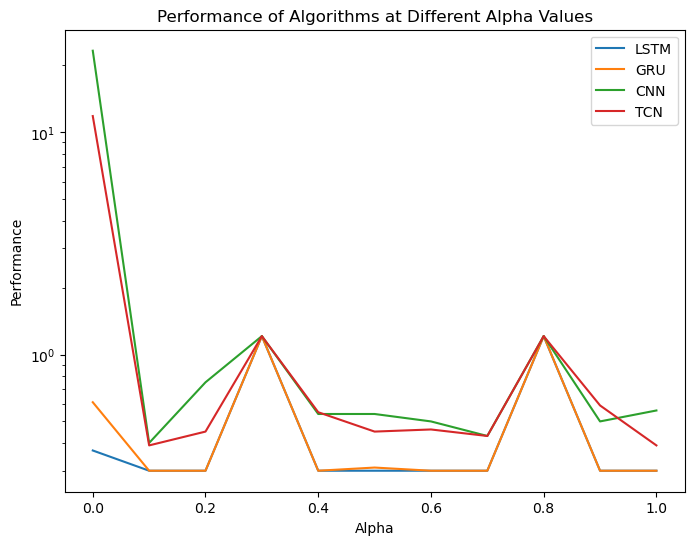

In [1]:
import matplotlib.pyplot as plt

alpha = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
lstm = [0.37, 0.3, 0.3, 1.21, 0.3, 0.3, 0.3, 0.3, 1.21, 0.3, 0.3]
gru = [0.61, 0.3, 0.3, 1.21, 0.3, 0.31, 0.3, 0.3, 1.21, 0.3, 0.3]
cnn = [23.28, 0.4, 0.75, 1.21, 0.54, 0.54, 0.5, 0.43, 1.21, 0.5, 0.56]
tcn = [11.83, 0.39, 0.45, 1.21, 0.55, 0.45, 0.46, 0.43, 1.21, 0.59, 0.39]

plt.figure(figsize=(8, 6))
plt.plot(alpha, lstm, label='LSTM')
plt.plot(alpha, gru, label='GRU')
plt.plot(alpha, cnn, label='CNN')
plt.plot(alpha, tcn, label='TCN')

plt.yscale('log')  # Set the y-axis to logarithmic scale

plt.xlabel('Alpha')
plt.ylabel('Performance')
plt.title('Performance of Algorithms at Different Alpha Values')
plt.legend()
plt.show()

In [1]:
 lat = 25.00
lon = -90.00

 coords = [lat, lon] * 2
 coords

[25.0, -90.0, 25.0, -90.0]